In [4]:
# !/usr/env python3

'''
Output:
video captioning model itself and produce loss curve

Usage:
main document to train the video captioning model
'''

# set up
from __future__ import print_function
import tensorflow as tf
import pickle
import os
import numpy as np
import logging
import matplotlib.pyplot as plt
from util import *
from model.video_caption import sequence_2_sequence_LSTM
from load_caption_feature import *
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import gc

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
model = None
gc.collect()

0

## Load Data  
load caption Xtrain, Xtest, ytrain, ytest, video_train, video_test and save them. 

In [ ]:
# load and save training data
num_frames = 15
size = (224, 224, 3)

# more balanced data
idx_path = os.getcwd() + '/datasets/x_train_ind_above400.npy'
Xtrain_idx = np.load(idx_path)
labels = np.load(os.getcwd() + '/datasets/y_train_mapped_above400.npy')

# if all videos then 
num_videos = len(Xtrain_idx)

tic = datetime.now()
# for clearing memory convenience
model = vgg_16_pretrained()
Xtr, ytr = load_features(model, num_videos, num_frames, Xtrain_idx, labels, size = (224, 224, 3), train_test_flag='train')

processing videos...
process 70/4270
process 140/4270
process 210/4270
process 280/4270
process 350/4270
process 420/4270
process 490/4270
process 560/4270
process 630/4270
process 700/4270
process 770/4270
process 840/4270
process 910/4270
process 980/4270
process 1050/4270
process 1120/4270
process 1190/4270
process 1260/4270
process 1330/4270
process 1400/4270
process 1470/4270
process 1540/4270
process 1610/4270
process 1680/4270
process 1750/4270
process 1820/4270

In [ ]:
# clear memory
del Xtr
del ytr
del 
model = None
gc.collect()

In [ ]:
# load and save test data
num_frames_test = 15
size = (224, 224, 3)

# more balanced data
idx_path = os.getcwd() + '/datasets/x_test_ind_above400.npy'
Xtest_idx = np.load(idx_path)
ytest = np.load(os.getcwd() + '/datasets/y_test_mapped_above400.npy')

# if all videos then 
num_videos_test = len(Xtest_idx)

model = vgg_16_pretrained()
Xte, yte = load_features(model, num_videos_test, num_frames_test, video_idx = Xtest_idx, labels = ytest, size = (224, 224, 3), train_test_flag='test')

In [ ]:
# clean memory
del Xte
del yte
model = None
gc.collect()

## Model setup and train

### Model Configuration and Parameters

In [2]:
# define parameters

logging.basicConfig(level=logging.INFO)
#=======Change These===============================
tf.app.flags.DEFINE_string("model_name", "baseline_1", "name of the model")
tf.app.flags.DEFINE_integer("state_size", 100, "Size of each model layer.")
tf.app.flags.DEFINE_float("learning_rate", 1e-2, "Base Learning rate.")
#==================================================

tf.app.flags.DEFINE_float("input_size", 7*7*512, "input size for each frame")
tf.app.flags.DEFINE_integer("batch_size", 10, "how many videos put per run")
tf.app.flags.DEFINE_integer("max_sentence_length", 20, "maximum captioning sentence length")
tf.app.flags.DEFINE_integer("word_vector_size", 50, "word embedding dimension default is 25 for twitter glove")
tf.app.flags.DEFINE_integer("voc_size", 6169, "vocabulary size")
tf.app.flags.DEFINE_integer("n_epochs", 100, "number of epoch to run")
tf.app.flags.DEFINE_integer("num_frames", 15, "number of frames per video")
tf.app.flags.DEFINE_integer("hidden_size", 100, "output size of LSTM encoder and decoder")
FLAGS = tf.app.flags.FLAGS        

### Load Training Data

In [3]:
def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

curPath = os.getcwd()
dataPath = curPath + "/datasets/"

# only pick first 100 for debugging purpose
# load data
sample_size = 100
wvector_dim = 50
is_training = True
input_frames_train, captions_train, \
        word_dict, word2Index, index2Word = load_caption_data(sample_size, dataPath, train = is_training)
word_embedding = word_embedding_array(word_dict, wvector_dim, word2Index) 
print('Finish loading training data!')

Finish loading training data!


### Build Model Graph

In [29]:
# build model graph
tf.reset_default_graph()
model = sequence_2_sequence_LSTM(word_embedding, FLAGS)
model.build()

start building model ...
total number of parameter 10799069


In [25]:
# check variables
for v in tf.trainable_variables():
    print(v)

<tf.Variable 'LSTM_seq2seq/encoder/basic_lstm_cell/weights:0' shape=(25188, 400) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/encoder/basic_lstm_cell/biases:0' shape=(400,) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/decoder/basic_lstm_cell/weights:0' shape=(250, 400) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/decoder/basic_lstm_cell/biases:0' shape=(400,) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/decoder/hidden_to_scores/kernel:0' shape=(100, 6169) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/decoder/hidden_to_scores/bias:0' shape=(6169,) dtype=float32_ref>


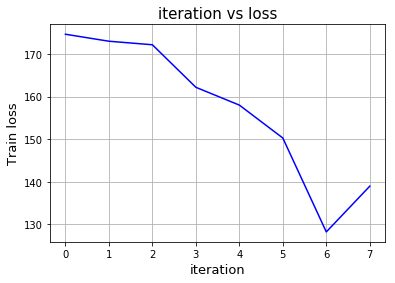

  1/100 [..............................] - ETA: 245s - train loss: 157.1636 - dev loss: 127.4764

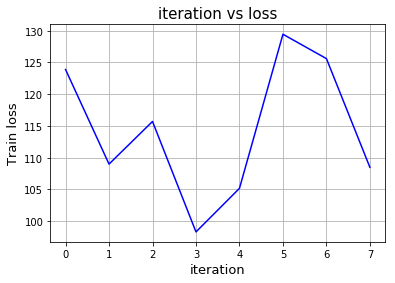

  2/100 [..............................] - ETA: 223s - train loss: 114.4543 - dev loss: 120.1125

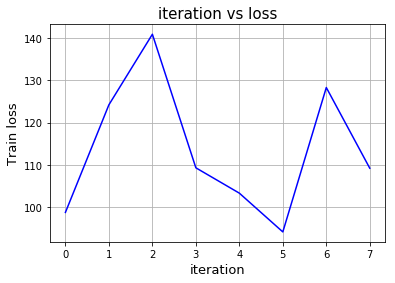

  3/100 [..............................] - ETA: 213s - train loss: 113.5206 - dev loss: 134.0122

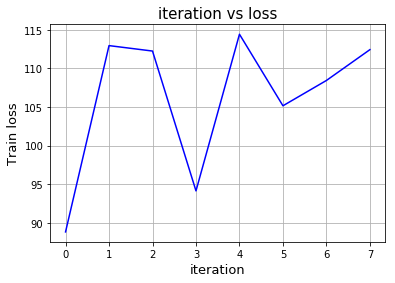

  4/100 [>.............................] - ETA: 207s - train loss: 106.0667 - dev loss: 132.2722

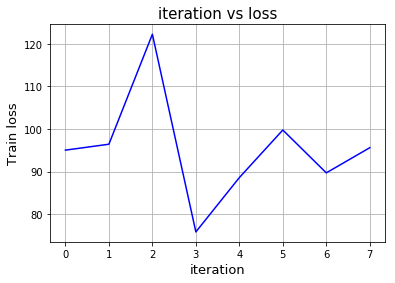

  5/100 [>.............................] - ETA: 203s - train loss: 95.3954 - dev loss: 141.6161 

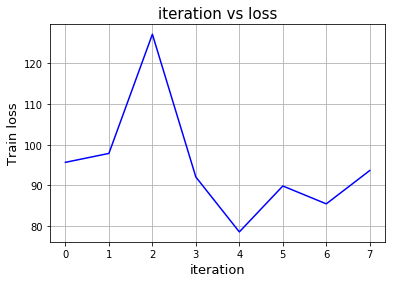

  6/100 [>.............................] - ETA: 199s - train loss: 95.0294 - dev loss: 173.6288

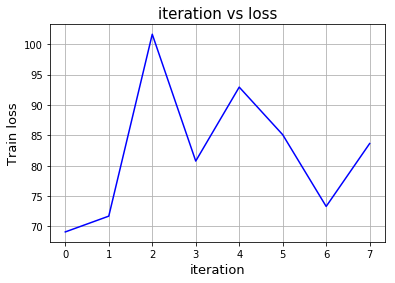

  7/100 [=>............................] - ETA: 196s - train loss: 82.2747 - dev loss: 163.4202

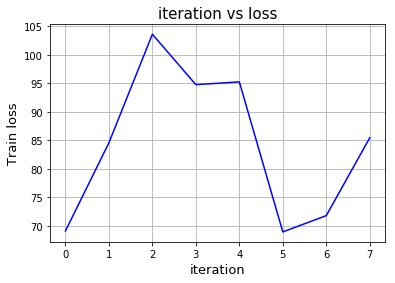

  8/100 [=>............................] - ETA: 194s - train loss: 84.1915 - dev loss: 151.9310

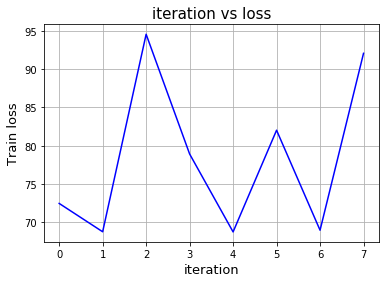

  9/100 [=>............................] - ETA: 191s - train loss: 78.3211 - dev loss: 165.3357

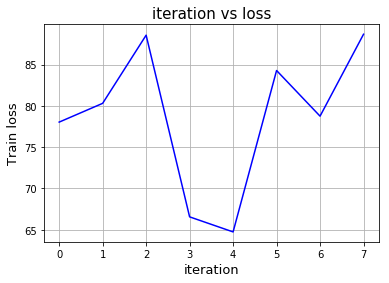

 10/100 [==>...........................] - ETA: 189s - train loss: 78.7379 - dev loss: 166.6688

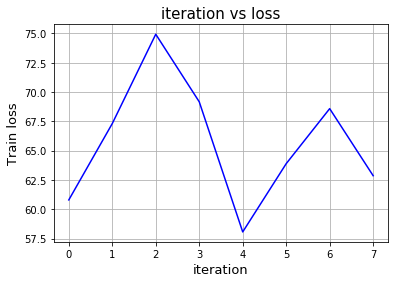

 11/100 [==>...........................] - ETA: 186s - train loss: 65.7003 - dev loss: 174.6523

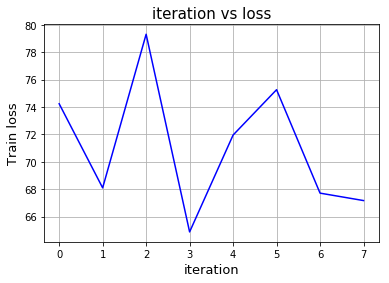

 12/100 [==>...........................] - ETA: 183s - train loss: 71.0779 - dev loss: 200.5887

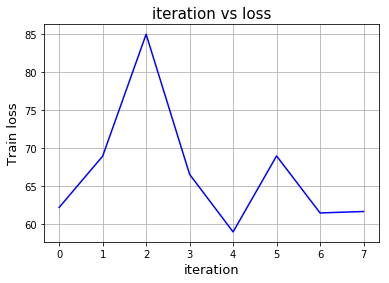

 13/100 [==>...........................] - ETA: 181s - train loss: 66.7299 - dev loss: 222.9537

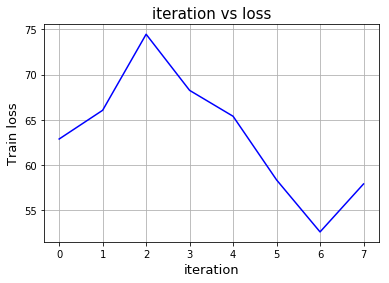

 14/100 [===>..........................] - ETA: 179s - train loss: 63.2267 - dev loss: 152.6606

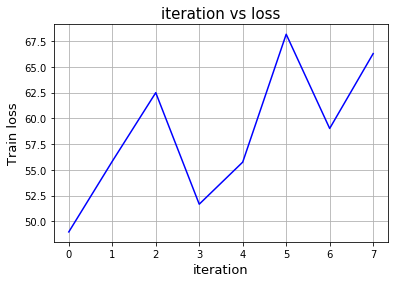

 15/100 [===>..........................] - ETA: 176s - train loss: 58.5225 - dev loss: 177.2100

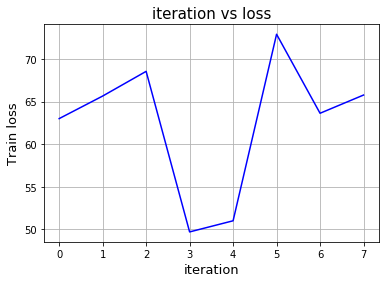

 16/100 [===>..........................] - ETA: 174s - train loss: 62.5246 - dev loss: 173.3808

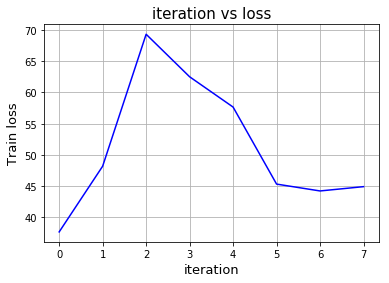

 17/100 [====>.........................] - ETA: 172s - train loss: 51.2303 - dev loss: 153.5603

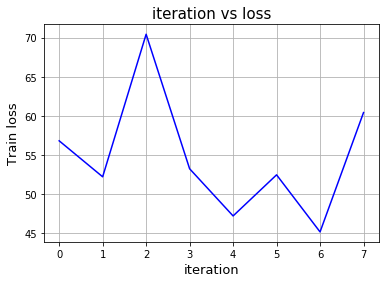

 18/100 [====>.........................] - ETA: 171s - train loss: 54.7339 - dev loss: 186.6789

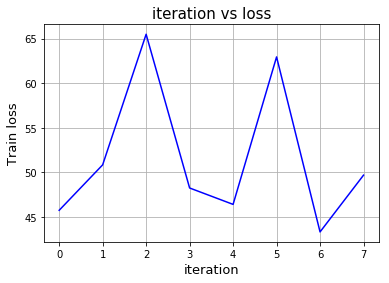

 19/100 [====>.........................] - ETA: 168s - train loss: 51.5963 - dev loss: 177.5511

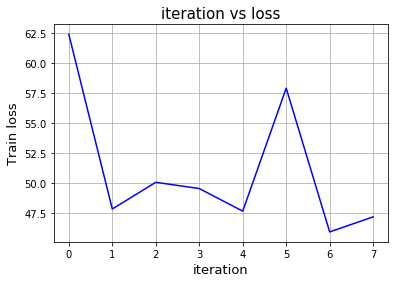

 20/100 [=====>........................] - ETA: 166s - train loss: 51.0526 - dev loss: 177.1242

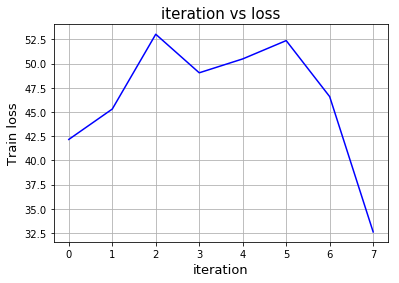

 21/100 [=====>........................] - ETA: 164s - train loss: 46.4484 - dev loss: 193.5838

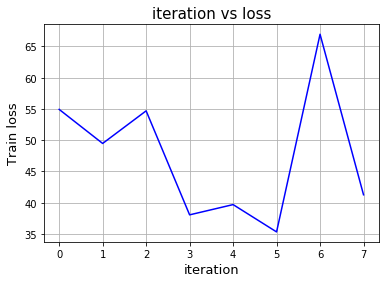

 22/100 [=====>........................] - ETA: 162s - train loss: 47.5523 - dev loss: 185.2621

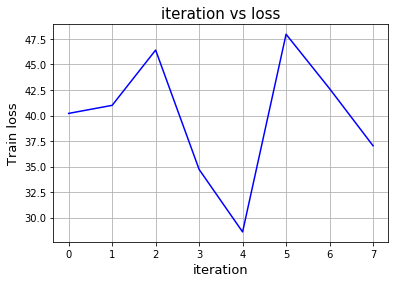

 23/100 [=====>........................] - ETA: 160s - train loss: 39.8202 - dev loss: 185.1695

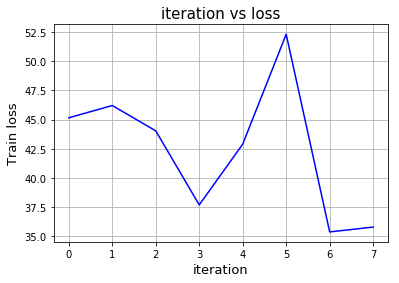

 24/100 [======>.......................] - ETA: 157s - train loss: 42.4324 - dev loss: 189.6829

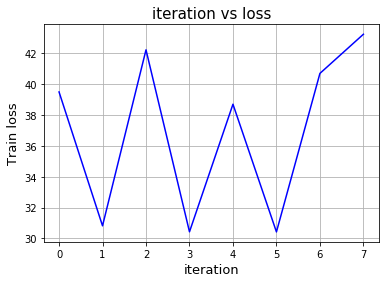

 25/100 [======>.......................] - ETA: 155s - train loss: 37.0084 - dev loss: 186.7384

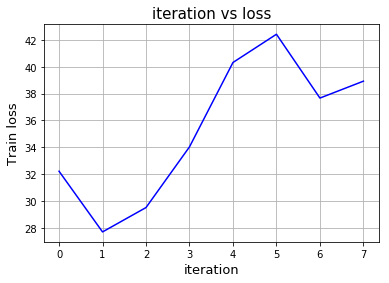

 26/100 [======>.......................] - ETA: 153s - train loss: 35.3487 - dev loss: 202.9774

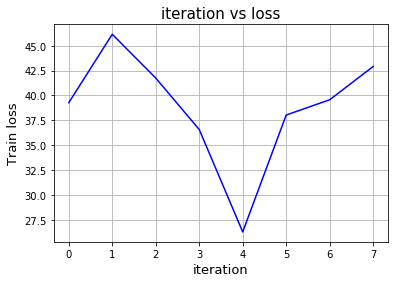

 27/100 [=======>......................] - ETA: 151s - train loss: 38.8233 - dev loss: 184.2142

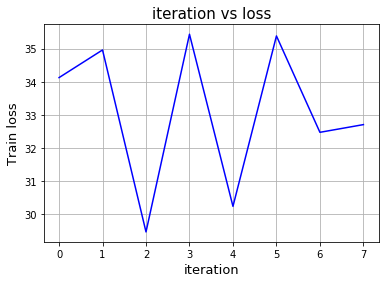

 28/100 [=======>......................] - ETA: 149s - train loss: 33.0950 - dev loss: 176.4785

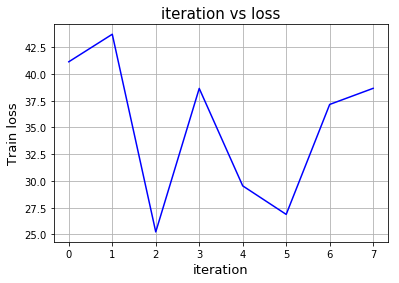

 29/100 [=======>......................] - ETA: 147s - train loss: 35.1162 - dev loss: 190.2873

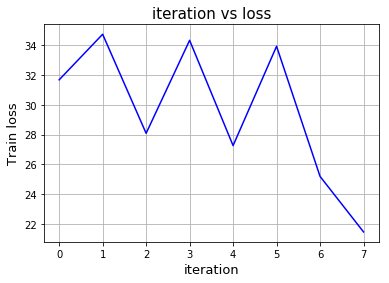

 30/100 [========>.....................] - ETA: 144s - train loss: 29.5885 - dev loss: 207.0006

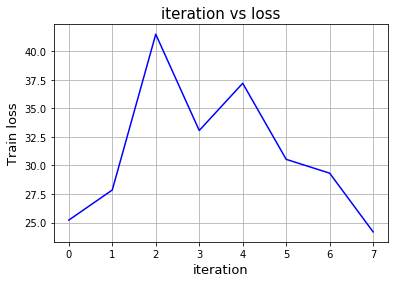

 31/100 [========>.....................] - ETA: 142s - train loss: 31.0999 - dev loss: 195.8099

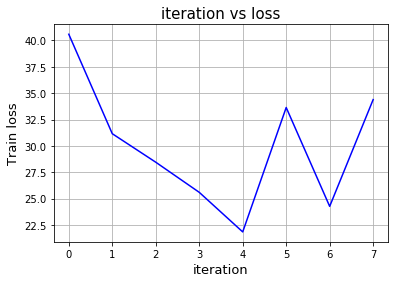

 32/100 [========>.....................] - ETA: 140s - train loss: 29.9921 - dev loss: 197.2305

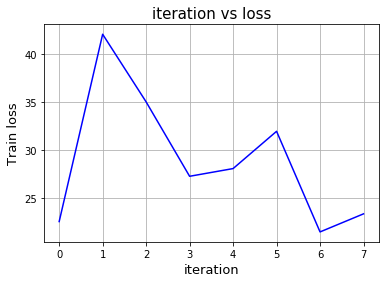

 33/100 [========>.....................] - ETA: 138s - train loss: 28.9495 - dev loss: 229.9218

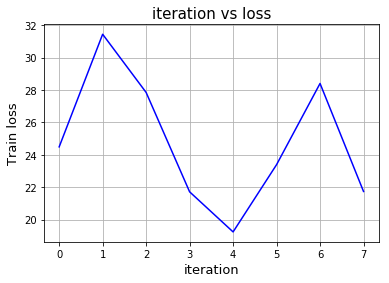

 34/100 [=========>....................] - ETA: 136s - train loss: 24.7822 - dev loss: 256.6183

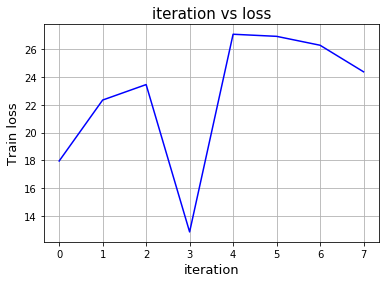

 35/100 [=========>....................] - ETA: 134s - train loss: 22.6494 - dev loss: 252.4859

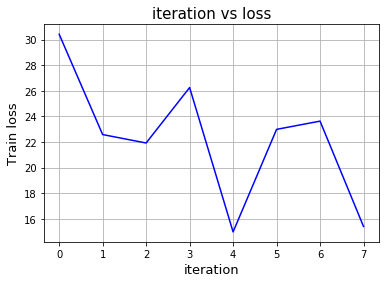

 36/100 [=========>....................] - ETA: 132s - train loss: 22.2666 - dev loss: 245.0014

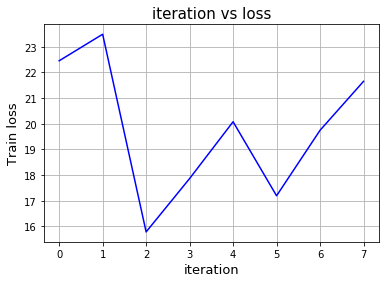

 37/100 [==========>...................] - ETA: 130s - train loss: 19.7837 - dev loss: 254.7958

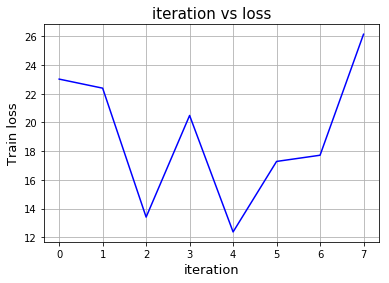

 38/100 [==========>...................] - ETA: 127s - train loss: 19.1009 - dev loss: 231.3815

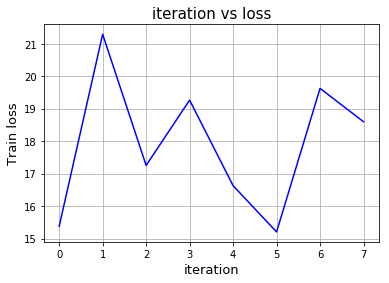

 39/100 [==========>...................] - ETA: 125s - train loss: 17.9050 - dev loss: 234.9783

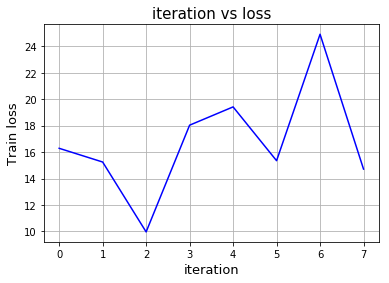

 40/100 [===========>..................] - ETA: 123s - train loss: 16.7411 - dev loss: 239.9410

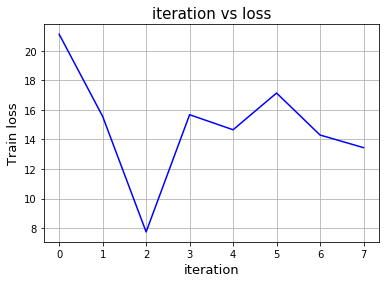

 41/100 [===========>..................] - ETA: 121s - train loss: 14.9561 - dev loss: 232.2483

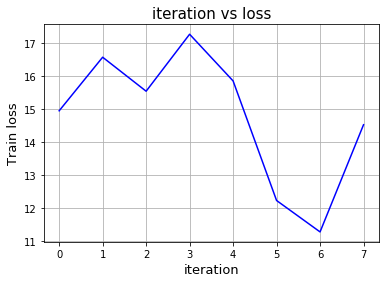

 42/100 [===========>..................] - ETA: 119s - train loss: 14.7830 - dev loss: 249.4641

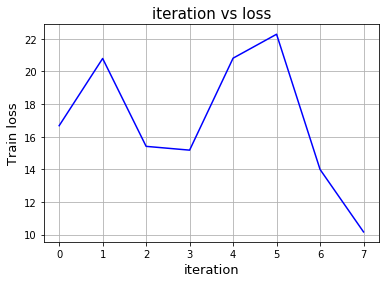

 43/100 [===========>..................] - ETA: 117s - train loss: 16.9145 - dev loss: 213.0537

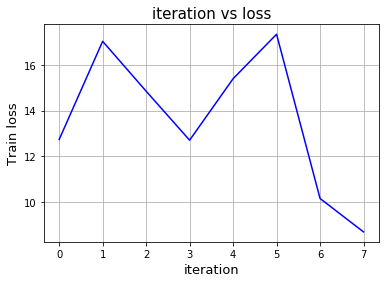

 44/100 [============>.................] - ETA: 115s - train loss: 13.6105 - dev loss: 224.3587

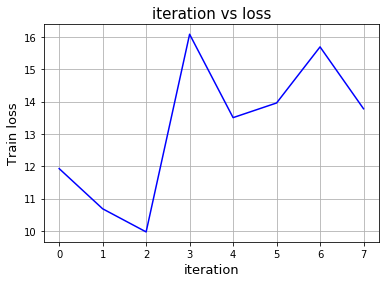

 45/100 [============>.................] - ETA: 113s - train loss: 13.1988 - dev loss: 244.2646

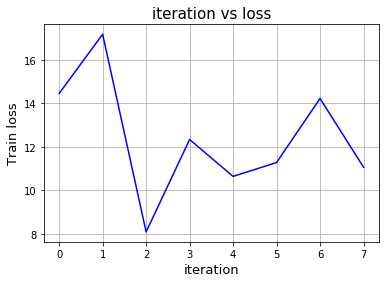

 46/100 [============>.................] - ETA: 111s - train loss: 12.4052 - dev loss: 248.1592

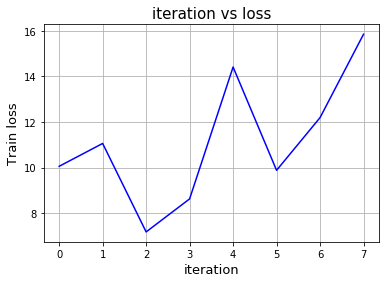

 47/100 [=============>................] - ETA: 109s - train loss: 11.1587 - dev loss: 244.2874

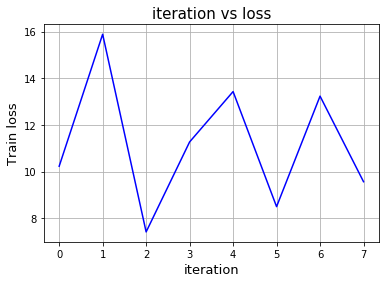

 48/100 [=============>................] - ETA: 107s - train loss: 11.1883 - dev loss: 230.7207

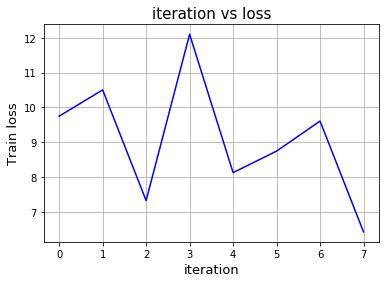

 49/100 [=============>................] - ETA: 105s - train loss: 9.0721 - dev loss: 251.7859 

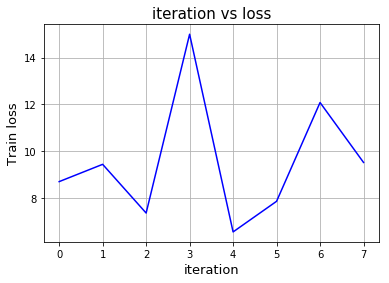

 50/100 [==============>...............] - ETA: 103s - train loss: 9.5668 - dev loss: 257.8051

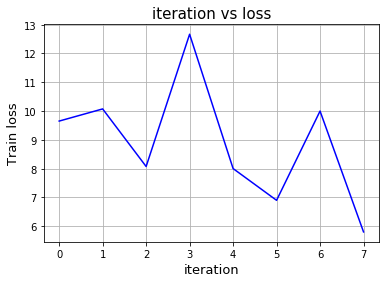

 51/100 [==============>...............] - ETA: 101s - train loss: 8.8974 - dev loss: 256.4691

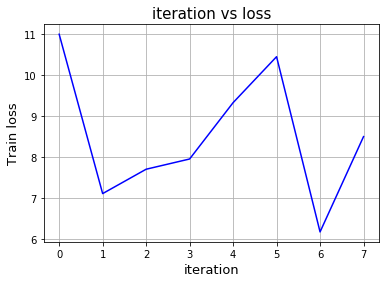

 52/100 [==============>...............] - ETA: 99s - train loss: 8.5217 - dev loss: 245.9462 

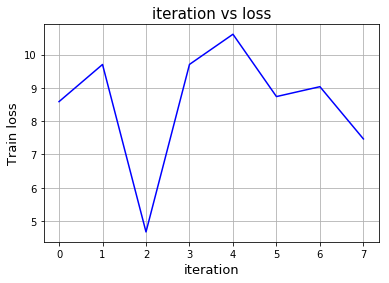

 53/100 [==============>...............] - ETA: 97s - train loss: 8.5650 - dev loss: 262.4933

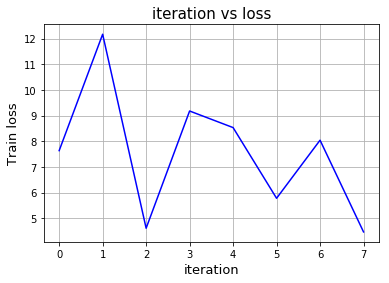

 54/100 [===============>..............] - ETA: 95s - train loss: 7.5500 - dev loss: 250.3860

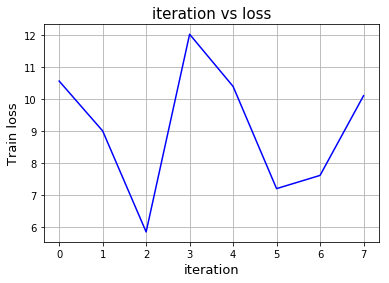

 55/100 [===============>..............] - ETA: 92s - train loss: 9.0961 - dev loss: 265.6837

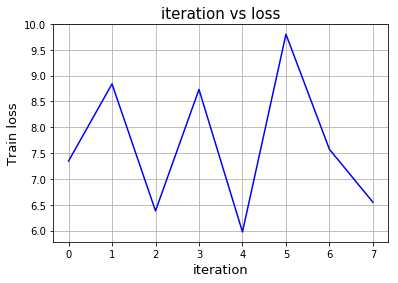

 56/100 [===============>..............] - ETA: 90s - train loss: 7.6487 - dev loss: 263.9770

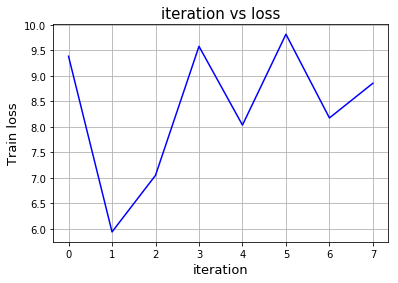

 57/100 [================>.............] - ETA: 88s - train loss: 8.3544 - dev loss: 256.1616

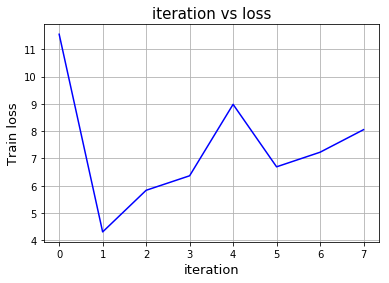

 58/100 [================>.............] - ETA: 86s - train loss: 7.3778 - dev loss: 260.5350

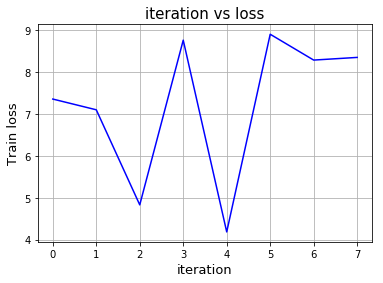

 59/100 [================>.............] - ETA: 84s - train loss: 7.2197 - dev loss: 262.8638

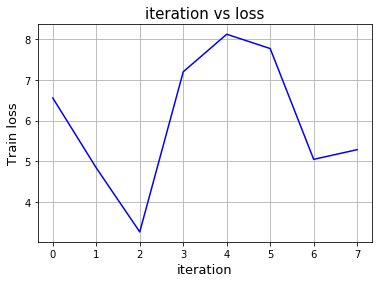

 60/100 [=================>............] - ETA: 82s - train loss: 6.0109 - dev loss: 246.0042

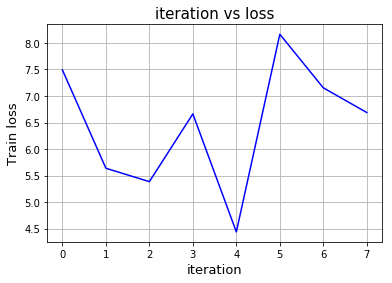

 61/100 [=================>............] - ETA: 80s - train loss: 6.4533 - dev loss: 268.6190

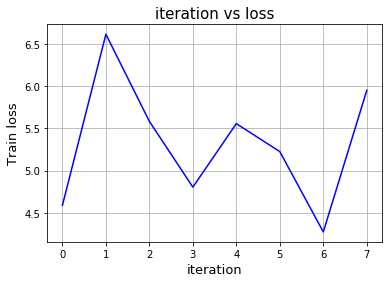

 62/100 [=================>............] - ETA: 78s - train loss: 5.3252 - dev loss: 281.4367

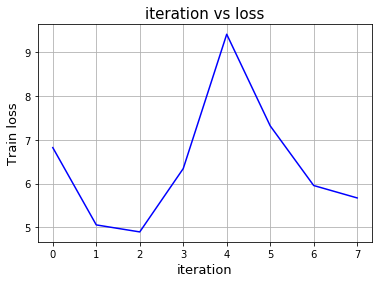

 63/100 [=================>............] - ETA: 76s - train loss: 6.4351 - dev loss: 255.9167

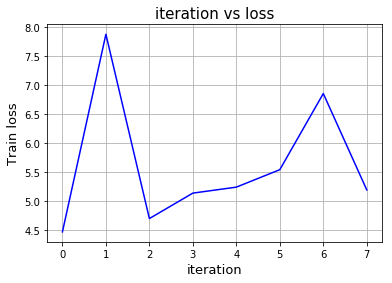

 64/100 [==================>...........] - ETA: 74s - train loss: 5.6323 - dev loss: 259.7273

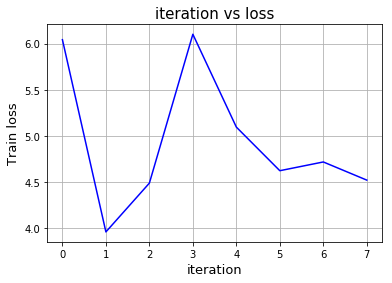

 65/100 [==================>...........] - ETA: 72s - train loss: 4.9438 - dev loss: 261.0432

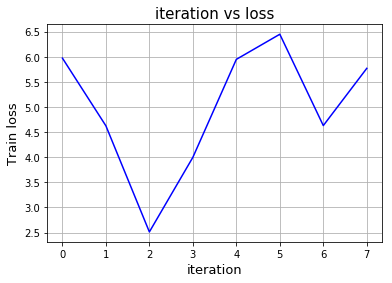

 66/100 [==================>...........] - ETA: 70s - train loss: 4.9873 - dev loss: 259.0479

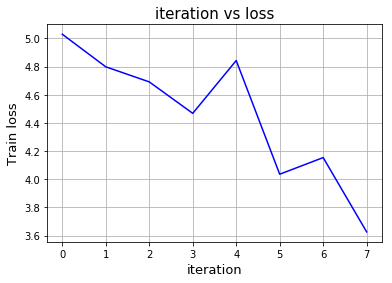

 67/100 [===================>..........] - ETA: 68s - train loss: 4.4554 - dev loss: 253.9685

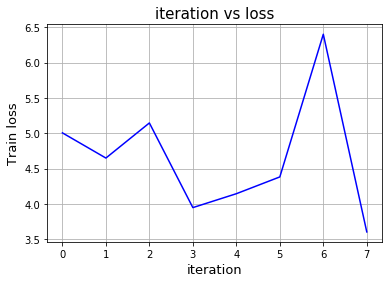

 68/100 [===================>..........] - ETA: 66s - train loss: 4.6588 - dev loss: 242.8046

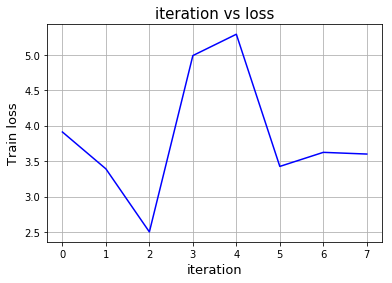

 69/100 [===================>..........] - ETA: 63s - train loss: 3.8410 - dev loss: 264.9091

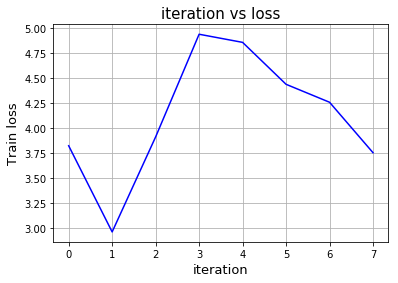

 70/100 [====================>.........] - ETA: 61s - train loss: 4.1194 - dev loss: 279.3251

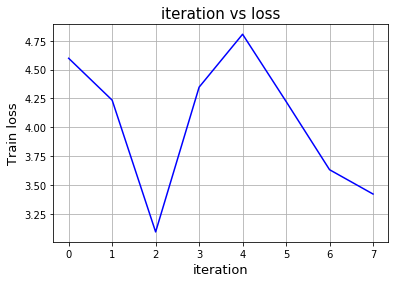

 71/100 [====================>.........] - ETA: 59s - train loss: 4.0456 - dev loss: 274.6721

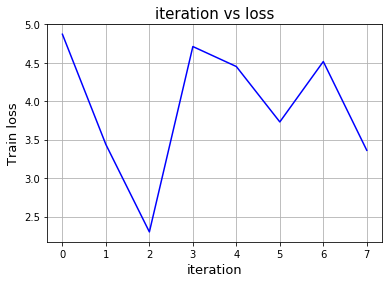

 72/100 [====================>.........] - ETA: 57s - train loss: 3.9222 - dev loss: 276.8636

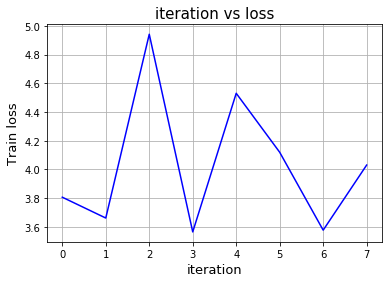

 73/100 [====================>.........] - ETA: 55s - train loss: 4.0290 - dev loss: 283.5612

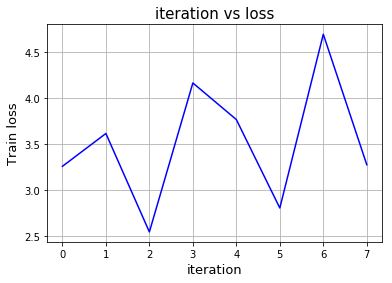

 74/100 [=====================>........] - ETA: 53s - train loss: 3.5166 - dev loss: 285.9559

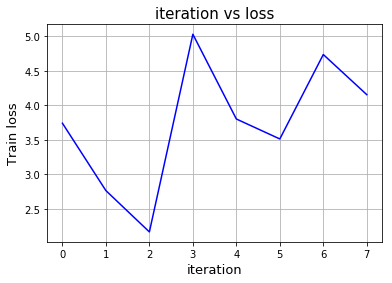

 75/100 [=====================>........] - ETA: 51s - train loss: 3.7398 - dev loss: 276.5464

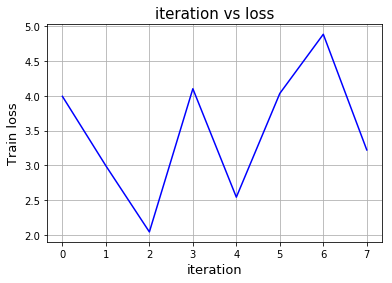

 76/100 [=====================>........] - ETA: 49s - train loss: 3.4759 - dev loss: 252.1934

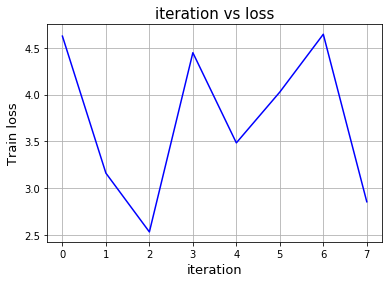

 77/100 [======================>.......] - ETA: 47s - train loss: 3.7224 - dev loss: 270.1999

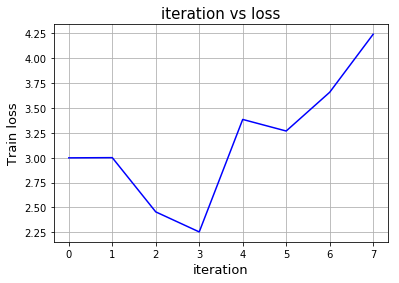

 78/100 [======================>.......] - ETA: 45s - train loss: 3.1569 - dev loss: 282.1740

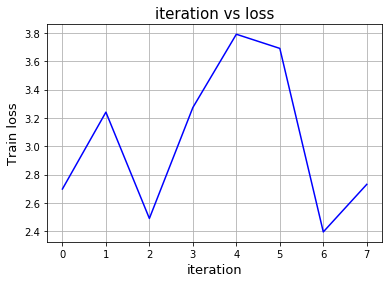

 79/100 [======================>.......] - ETA: 43s - train loss: 3.0389 - dev loss: 278.1754

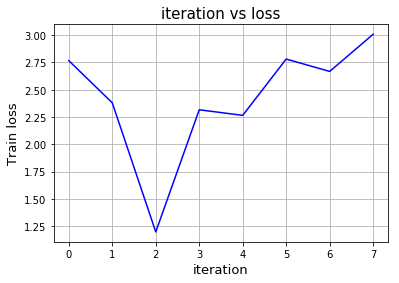

 80/100 [=======================>......] - ETA: 41s - train loss: 2.4230 - dev loss: 289.7474

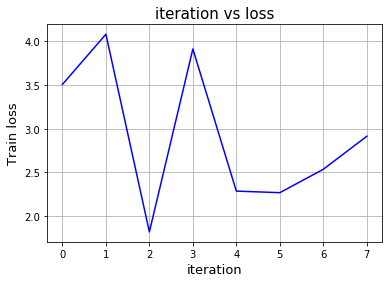

 81/100 [=======================>......] - ETA: 39s - train loss: 2.9152 - dev loss: 287.9523

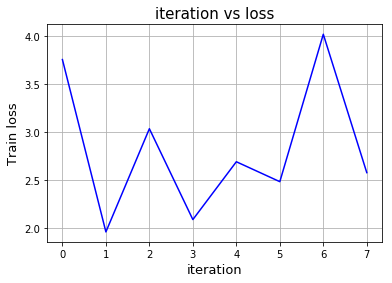

 82/100 [=======================>......] - ETA: 37s - train loss: 2.8243 - dev loss: 255.3509

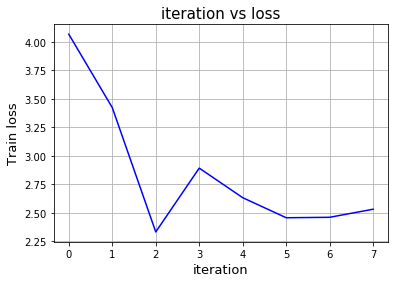

 83/100 [=======================>......] - ETA: 35s - train loss: 2.8496 - dev loss: 293.3119

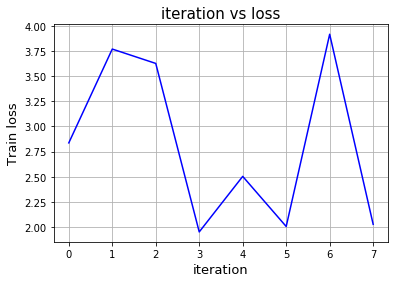

 84/100 [========================>.....] - ETA: 33s - train loss: 2.8299 - dev loss: 280.8722

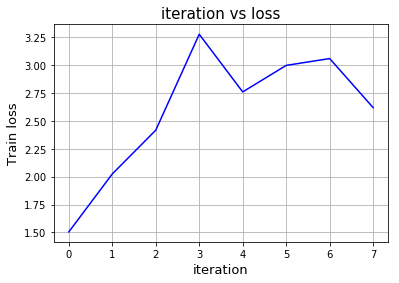

 85/100 [========================>.....] - ETA: 30s - train loss: 2.5813 - dev loss: 300.9667

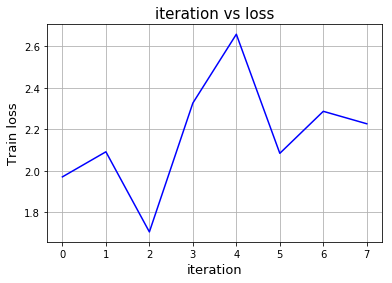

 86/100 [========================>.....] - ETA: 28s - train loss: 2.1683 - dev loss: 300.7894

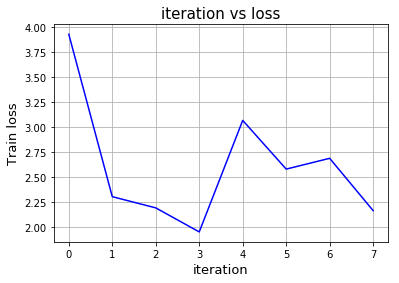

 87/100 [=========================>....] - ETA: 26s - train loss: 2.6118 - dev loss: 292.8739

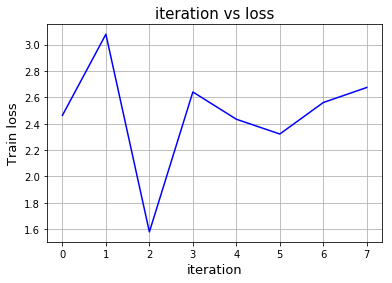

 88/100 [=========================>....] - ETA: 24s - train loss: 2.4692 - dev loss: 273.8214

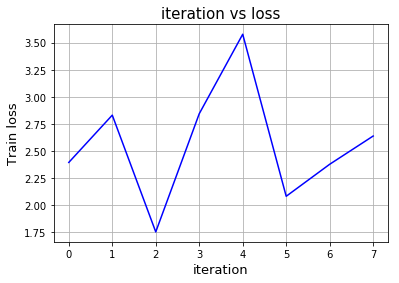

 89/100 [=========================>....] - ETA: 22s - train loss: 2.5620 - dev loss: 288.2710

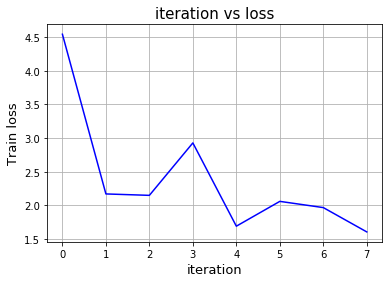

 90/100 [==========================>...] - ETA: 20s - train loss: 2.3887 - dev loss: 286.0892

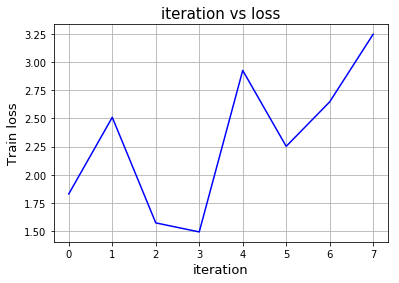

 91/100 [==========================>...] - ETA: 18s - train loss: 2.3098 - dev loss: 300.6489

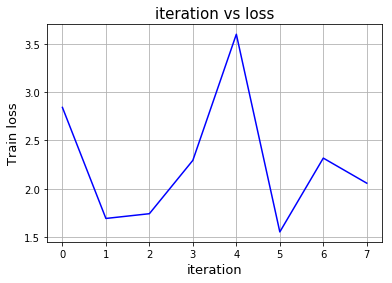

 92/100 [==========================>...] - ETA: 16s - train loss: 2.2615 - dev loss: 293.2694

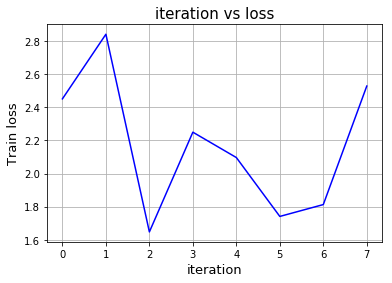

 93/100 [==========================>...] - ETA: 14s - train loss: 2.1707 - dev loss: 287.5620

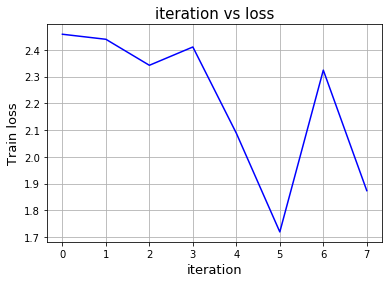

 94/100 [===========================>..] - ETA: 12s - train loss: 2.2069 - dev loss: 283.5868

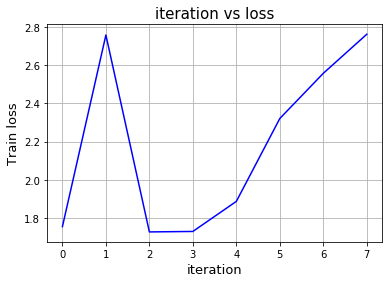

 95/100 [===========================>..] - ETA: 10s - train loss: 2.1872 - dev loss: 280.4750

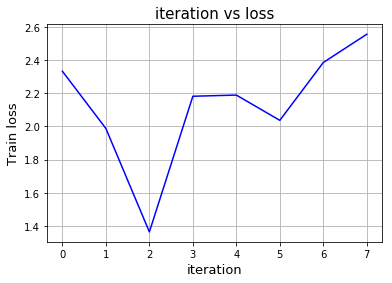

 96/100 [===========================>..] - ETA: 8s - train loss: 2.1287 - dev loss: 282.8585 

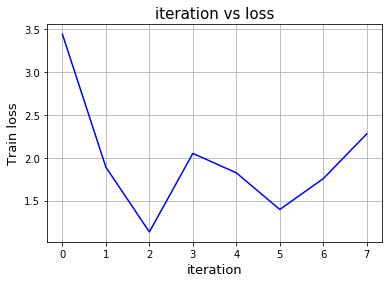

 97/100 [============================>.] - ETA: 6s - train loss: 1.9710 - dev loss: 303.8934

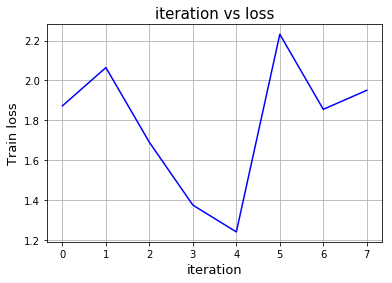

 98/100 [============================>.] - ETA: 4s - train loss: 1.7854 - dev loss: 285.3401

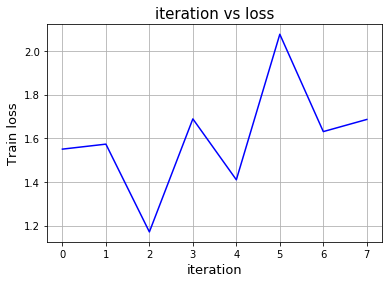

 99/100 [============================>.] - ETA: 2s - train loss: 1.5980 - dev loss: 285.4083

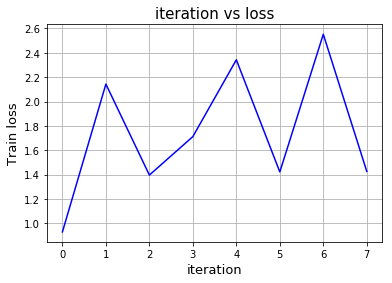

100/100 [==============================] - 206s - train loss: 1.7405 - dev loss: 290.5630   


In [30]:
# run training mode
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    val_loss, tr_loss, tr_pred, val_pred, batch_vid \
            = model.train(sess, (input_frames_train, captions_train), verbose = True)

### Plot Learning Curves

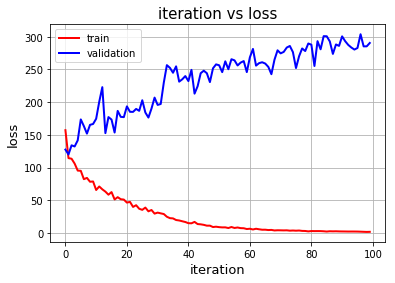

In [31]:
# plot learning curve
plt.plot(range(len(tr_loss)), tr_loss, 'r-', linewidth = 2, label = 'train')
plt.plot(range(len(val_loss)), val_loss, 'b-', linewidth = 2, label = 'validation')
plt.grid()
plt.xlabel('iteration', fontsize = 13)
plt.ylabel('loss', fontsize = 13)
plt.title('iteration vs loss', fontsize = 15)
plt.legend()
plt.savefig(os.getcwd() + '/output/caption_learning_curve.png')

In [47]:
# check captions
batch_size = 10
sample = tr_pred[idx] # training
# sample = val_pred[idx] # validation 
words = []
embed_train = False # whether train embedding word

captions = {k: v for k, v in captions_train}
# caption check
for j in range(batch_size):
    words = []
    trues = []
    sample = tr_pred[j]
    vid = batch_vid[j]
    cap = captions[vid]
    for idx, i in enumerate(sample):
        word = index2Word[i]
        true = index2Word[cap[idx]]
        if word not in ['<START>', '<END>', '<pad>']:
            words.append(word)
        if true not in ['<START>', '<END>', '<pad>']:
            trues.append(true)   
    print('Pred Caption: ', ' '.join(w for w in words))
    print('True Caption: ', ' '.join(t for t in trues))
    print('-'*50)

Pred Caption:  the scene shows the animated figures
True Caption:  an painting of different religion in sorrow
--------------------------------------------------
Pred Caption:  there is a racing competition between some men
True Caption:  a couple of scene that is coming from a movie
--------------------------------------------------
Pred Caption:  aboard aboard aboard aboard aboard aboard aboard aboard aboard aboard aboard aboard aboard aboard aboard aboard aboard aboard aboard aboard
True Caption:  a person jumps around in an rug like video game while boasting a jetpack
--------------------------------------------------
Pred Caption:  a man demonstrates a cell phone pp
True Caption:  a man demonstrates a cell phone pp
--------------------------------------------------
Pred Caption:  afraid afraid afraid afraid afraid afraid afraid afraid afraid afraid afraid afraid afraid afraid afraid afraid afraid afraid afraid afraid
True Caption:  a man shoots a rope while another man is climbing

### Check Test Prediction and Evaluation